In [1]:
# Import Required Libraries
from pathlib import Path
import pandas as pd
import json
import requests
import numpy as np

In [2]:
# Import Required Libraries
from pathlib import Path
import pandas as pd
import json
import requests
import numpy as np
import matplotlib.pyplot as plt
import gzip

In [3]:
# Define constants for file paths and URLs
CISA_URL: str = "https://www.cisa.gov/sites/default/files/csv/known_exploited_vulnerabilities.csv"
EPSS_URL: str = "https://epss.empiricalsecurity.com/epss_scores-current.csv.gz"
NVD_URL_TEMPLATE: str = "https://nvd.nist.gov/feeds/json/cve/2.0/nvdcve-2.0-{year}.json.zip"
DATA_DIR: Path = Path("data")

# Create data directory if it doesn't exist
DATA_DIR.mkdir(exist_ok=True)

In [4]:
# Download and save a file locally with proper headers
def download_file(url: str, dest: Path) -> None:
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
        "Accept": "*/*",
        "Connection": "keep-alive",
    }
    try:
        response = requests.get(url, headers=headers, stream=True, allow_redirects=True)
        print(f"Request URL: {url}")
        print(f"Final URL after redirects: {response.url}")
        print(f"Response Status Code: {response.status_code}")
        response.raise_for_status()
        with open(dest, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print(f"Downloaded: {response.url}")
    except Exception as e:
        print(f"Failed to download {url}: {e}")

# Download CISA KEV data
cisa_file = DATA_DIR / "known_exploited_vulnerabilities.csv"
download_file(CISA_URL, cisa_file)

# Download EPSS data (gzipped)
epss_gz_file = DATA_DIR / "epss_scores-current.csv.gz"
download_file(EPSS_URL, epss_gz_file)

# Unzip EPSS data
epss_file = DATA_DIR / "epss_scores-current.csv"
try:
    with gzip.open(epss_gz_file, 'rb') as f_in:
        with open(epss_file, 'wb') as f_out:
            f_out.write(f_in.read())
    print("EPSS data unzipped successfully.")
except Exception as e:
    print(f"Failed to unzip EPSS data: {e}")

Request URL: https://www.cisa.gov/sites/default/files/csv/known_exploited_vulnerabilities.csv
Final URL after redirects: https://www.cisa.gov/sites/default/files/csv/known_exploited_vulnerabilities.csv
Response Status Code: 200
Downloaded: https://www.cisa.gov/sites/default/files/csv/known_exploited_vulnerabilities.csv
Request URL: https://epss.empiricalsecurity.com/epss_scores-current.csv.gz
Final URL after redirects: https://epss.empiricalsecurity.com/epss_scores-2025-12-12.csv.gz
Response Status Code: 200
Downloaded: https://www.cisa.gov/sites/default/files/csv/known_exploited_vulnerabilities.csv
Request URL: https://epss.empiricalsecurity.com/epss_scores-current.csv.gz
Final URL after redirects: https://epss.empiricalsecurity.com/epss_scores-2025-12-12.csv.gz
Response Status Code: 200
Downloaded: https://epss.empiricalsecurity.com/epss_scores-2025-12-12.csv.gz
EPSS data unzipped successfully.
Downloaded: https://epss.empiricalsecurity.com/epss_scores-2025-12-12.csv.gz
EPSS data unz

In [5]:
# Load and preprocess CISA KEV data
try:
    cisa_df = pd.read_csv(cisa_file)
    cisa_df.columns = cisa_df.columns.str.strip("\u200b")
    cisa_df = cisa_df.rename(columns={"cveID": "CVE", "shortDescription": "Description", "vendorProject": "Vendor", "product": "Product"})
    print("CISA data loaded successfully.")
except Exception as e:
    print(f"Error loading CISA KEV data: {e}")

CISA data loaded successfully.


In [6]:
# Load and preprocess EPSS data
try:
    epss = pd.read_csv(epss_file, skiprows=1)
    epss = epss.rename(columns={"cve": "CVE", "epss": "EPSS", "percentile": "EPSS Percentile"})
    print("EPSS data loaded successfully.")
except Exception as e:
    print(f"Error loading EPSS data: {e}")

EPSS data loaded successfully.


In [7]:
# Download and extract NVD JSON files (2.0 feed)
import zipfile

def download_and_extract_nvd(year: int) -> None:
    url = NVD_URL_TEMPLATE.format(year=year)
    zip_path = DATA_DIR / f"nvdcve-2.0-{year}.json.zip"
    json_path = DATA_DIR / f"nvdcve-2.0-{year}.json"

    download_file(url, zip_path)

    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(DATA_DIR)
        print(f"Extracted: {zip_path}")
    except Exception as e:
        print(f"Failed to extract {zip_path}: {e}")

# Download and extract NVD data for recent years
for year in range(2020, 2026):
    download_and_extract_nvd(year)

Request URL: https://nvd.nist.gov/feeds/json/cve/2.0/nvdcve-2.0-2020.json.zip
Final URL after redirects: https://nvd.nist.gov/feeds/json/cve/2.0/nvdcve-2.0-2020.json.zip
Response Status Code: 200
Downloaded: https://nvd.nist.gov/feeds/json/cve/2.0/nvdcve-2.0-2020.json.zip
Downloaded: https://nvd.nist.gov/feeds/json/cve/2.0/nvdcve-2.0-2020.json.zip
Extracted: data/nvdcve-2.0-2020.json.zip
Extracted: data/nvdcve-2.0-2020.json.zip
Request URL: https://nvd.nist.gov/feeds/json/cve/2.0/nvdcve-2.0-2021.json.zip
Final URL after redirects: https://nvd.nist.gov/feeds/json/cve/2.0/nvdcve-2.0-2021.json.zip
Response Status Code: 200
Request URL: https://nvd.nist.gov/feeds/json/cve/2.0/nvdcve-2.0-2021.json.zip
Final URL after redirects: https://nvd.nist.gov/feeds/json/cve/2.0/nvdcve-2.0-2021.json.zip
Response Status Code: 200
Downloaded: https://nvd.nist.gov/feeds/json/cve/2.0/nvdcve-2.0-2021.json.zip
Extracted: data/nvdcve-2.0-2021.json.zip
Downloaded: https://nvd.nist.gov/feeds/json/cve/2.0/nvdcve

In [8]:
# Process NVD JSON files and extract CVSS3 scores
row_accumulator = []
nvd_files = DATA_DIR.glob("nvdcve-2.0-*.json")

for filename in nvd_files:
    try:
        with open(filename, 'r', encoding='utf-8') as f:
            nvd_data = json.load(f)
            for entry in nvd_data['vulnerabilities']:
                cve = entry['cve']['id']
                base_score = 0.0
                metrics = entry['cve'].get('metrics', {})
                cvss_v31 = metrics.get('cvssMetricV31', [{}])
                if cvss_v31 and 'cvssData' in cvss_v31[0]:
                    base_score = cvss_v31[0]['cvssData'].get('baseScore', 0.0)
                row_accumulator.append({
                    'CVE': cve,
                    'CVSS3': base_score,
                })
    except Exception as e:
        print(f"Error processing file {filename}: {e}")

# Create DataFrame after all files are processed
nvd = pd.DataFrame(row_accumulator)
nvd['CVSS3'] = pd.to_numeric(nvd['CVSS3'], errors='coerce')
nvd['CVSS3'] = nvd['CVSS3'].replace(0, np.nan)
print("NVD data processed successfully.")

NVD data processed successfully.


In [9]:
# Merge datasets to create a comprehensive DataFrame
epss_kev = pd.merge(cisa_df, epss, on='CVE', how='inner')
epss_kev_nvd = pd.merge(epss_kev, nvd, on='CVE', how='inner')
epss_kev_nvd = epss_kev_nvd[["CVE", "CVSS3", "EPSS", "EPSS Percentile", "Description", "Vendor", "Product"]]

# Display the merged DataFrame
epss_kev_nvd.head()

,CVE,CVSS3,EPSS,EPSS Percentile,Description,Vendor,Product
0,CVE-2025-58360,8.2,0.73168,0.98730,OSGeo GeoServer contains an improper restricti...,OSGeo,GeoServer
1,CVE-2025-6218,NaN,0.07167,0.91237,RARLAB WinRAR contains a path traversal vulner...,RARLAB,WinRAR
2,CVE-2025-62221,7.8,0.04173,0.88305,Microsoft Windows Cloud Files Mini Filter Driv...,Microsoft,Windows
3,CVE-2022-37055,9.8,0.73907,0.98766,D-Link Routers contains a buffer overflow vuln...,D-Link,Routers
4,CVE-2025-66644,7.2,0.03130,0.86422,Array Networks ArrayOS AG contains an OS comma...,Array Networks,ArrayOS AG


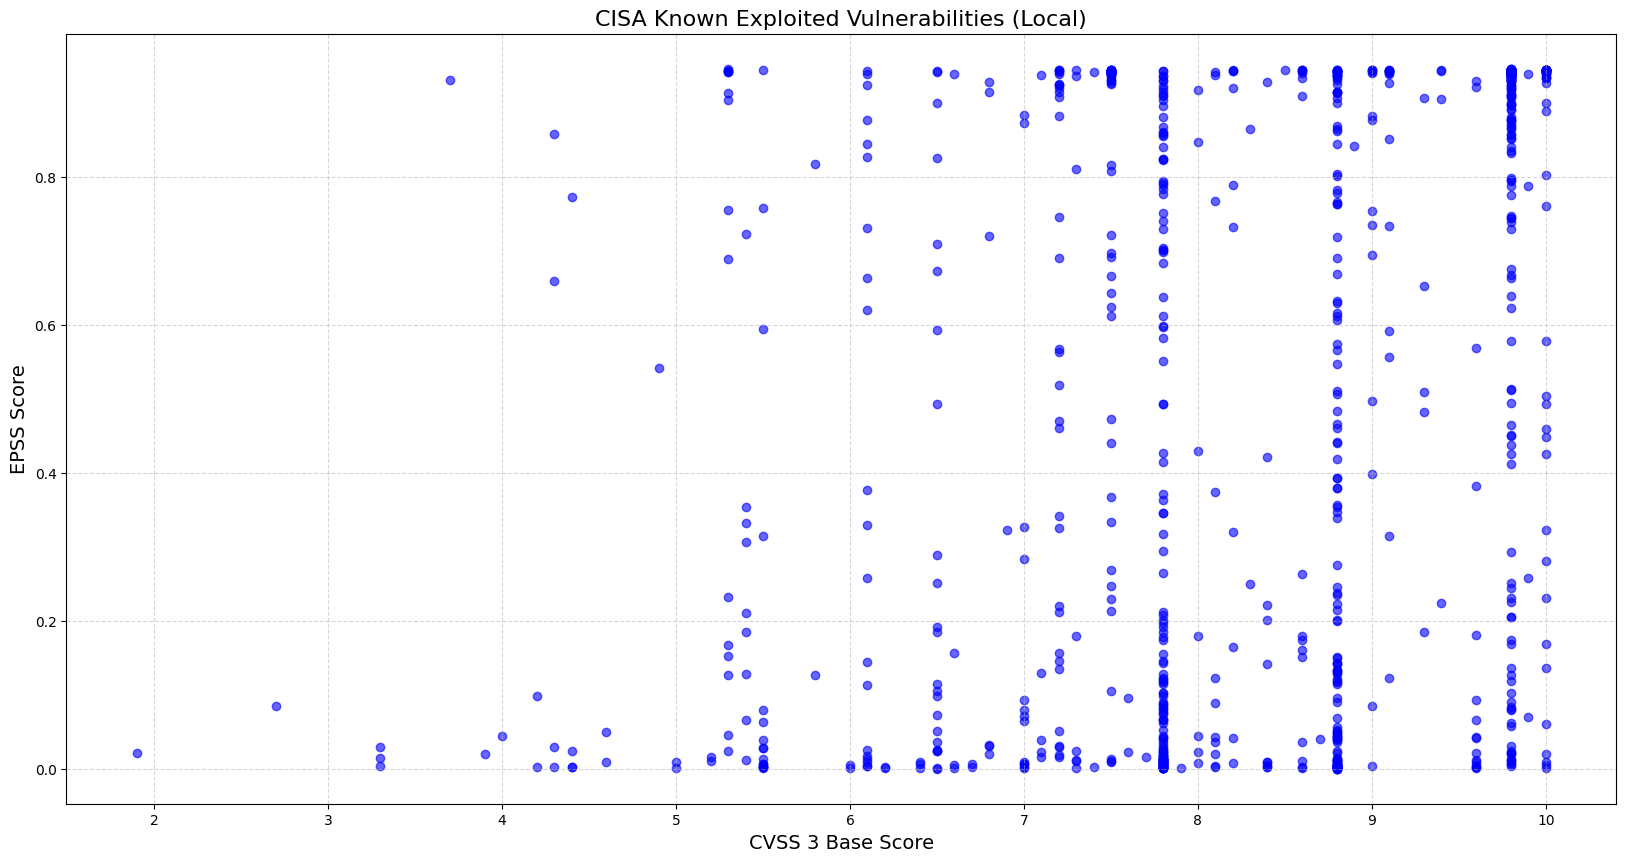

In [10]:
# Create a scatter plot to visualize the data
plt.figure(figsize=(20, 10))
plt.scatter(epss_kev_nvd['CVSS3'], epss_kev_nvd['EPSS'], color='blue', alpha=0.6)
plt.title('CISA Known Exploited Vulnerabilities (Local)', fontsize=16)
plt.xlabel('CVSS 3 Base Score', fontsize=14)
plt.ylabel('EPSS Score', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig('epss_kev_nvd_local.png')
plt.show()

In [11]:
# Export the DataFrame to a CSV file
epss_kev_nvd.to_csv("epss_kev_nvd_local.csv", index=False)
print("Exported epss_kev_nvd_local.csv successfully.")

# Display the first 10 rows of the DataFrame
epss_kev_nvd.head(10)

Exported epss_kev_nvd_local.csv successfully.


,CVE,CVSS3,EPSS,EPSS Percentile,Description,Vendor,Product
0,CVE-2025-58360,8.2,0.73168,0.98730,OSGeo GeoServer contains an improper restricti...,OSGeo,GeoServer
1,CVE-2025-6218,NaN,0.07167,0.91237,RARLAB WinRAR contains a path traversal vulner...,RARLAB,WinRAR
2,CVE-2025-62221,7.8,0.04173,0.88305,Microsoft Windows Cloud Files Mini Filter Driv...,Microsoft,Windows
3,CVE-2022-37055,9.8,0.73907,0.98766,D-Link Routers contains a buffer overflow vuln...,D-Link,Routers
4,CVE-2025-66644,7.2,0.03130,0.86422,Array Networks ArrayOS AG contains an OS comma...,Array Networks,ArrayOS AG
5,CVE-2025-55182,10.0,0.76008,0.98865,Meta React Server Components contains a remote...,Meta,React Server Components
6,CVE-2021-26828,8.8,0.80120,0.99067,OpenPLC ScadaBR contains an unrestricted uploa...,OpenPLC,ScadaBR
7,CVE-2025-48633,5.5,0.00355,0.57229,Android Framework contains an unspecified vuln...,Android,Framework
8,CVE-2025-48572,7.8,0.00595,0.68578,Android Framework contains an unspecified vuln...,Android,Framework
9,CVE-2021-26829,5.4,0.35401,0.96878,OpenPLC ScadaBR contains a cross-site scriptin...,OpenPLC,ScadaBR
